In [172]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [173]:
plt.rcParams['figure.figsize'] = (10,6)

## Week 8: OpenStreetMap and Urban Networks
March 25, 2019

## The roadmap

- Last week Big data: dask and datashader
- Today + next week: "geo data science in the wild"
    - Profiling useful tools for real-life applications
    - A little bit more "lab" based
- Several weeks of web-based data visualization

## Housekeeping

- HW #5 is due in 1 1/2 weeks (April 5)
    - Covers web scraping and big data
- Look for graded homeworks to be uploaded in the next week days
- We'll review final project guidelines next week, written proposal due in about a month 

## Today: OpenStreetMap (OSM)

- Two tools that make working with OSM data very easy
- What kind of questions can we answer?
    - Street orientations 
    - Mapping event points to streets: car crashes
    - Mapping amenities
    - Network-constrained distances: accessibility

## OSM: what is it?

- Collaborative mapping
- A free editable map of the World
- Sort of like Wikipedia for maps

**Great source of data: street networks and a wealth of amenity information**

https://www.openstreetmap.org

## Working with OSM data

- Raw data is very messy
- Two relatively new, amazing Python packages greatly simply the process
- Related, but complementary features    
    - **OSMnx:** downloading and manipulating streets as networks
    - **Pandana:** networks focused on accessibility of amenities

## Part 1: OSMnx

Several key features: 

- Downloading political boundaries for cities, states, countries, etc
- Downloading street networks
- Analyzing networks: routing, visualization, statistics

  - [GitHub](https://github.com/gboeing/osmnx)
  - [Introductory Blog Post](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Jupyter Notebook Examples](https://github.com/gboeing/osmnx-examples/tree/master/notebooks)
  - [Documentation](https://osmnx.readthedocs.io)

In [86]:
import osmnx as ox

## Getting OSM shapefiles

Key function: `gdf_from_place()`

**Important: Be careful to pass the right place name that OSM needs**

In [87]:
philly = ox.gdf_from_place('Philadelphia, PA, USA')
philly.head()

bbox_east  bbox_north  bbox_south  bbox_west  \
0 -74.955831   40.137959   39.867005 -75.280298   

                                            geometry  \
0  POLYGON ((-75.28029770000001 39.9750019, -75.2...   

                                          place_name  
0  Philadelphia, Philadelphia County, Pennsylvani...

We can plot it just like any other GeoDataFrame

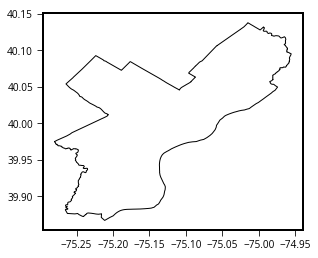

In [94]:
philly.plot(facecolor='none', edgecolor='black')

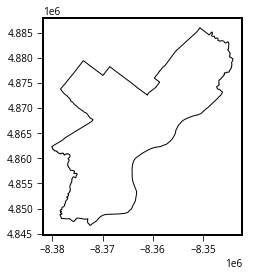

In [95]:
# or project it to Web Mercator first
philly.to_crs(epsg=3857).plot(facecolor='none', edgecolor='black')

## Projecting and plotting with OSMnx

Key functions: 
- `project_gdf()`: automatically projects to Universal Transverse Mercator (UTM)
- `plot_shape()`

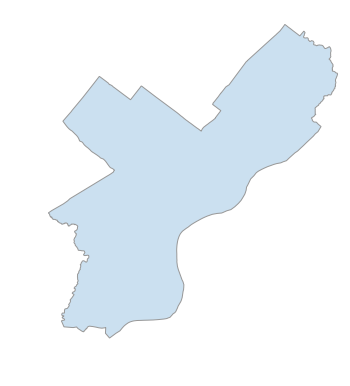

In [101]:
# an automatic, nice looking plot
ox.plot_shape(ox.project_gdf(philly));

We can get the boundary for anything identified as a "place" by OSM

In [111]:
# some examples
place1 = ox.gdf_from_place('Manhattan, New York City, New York, USA')
place2 = ox.gdf_from_place('Miami-Dade County, Florida')
place3 = ox.gdf_from_place('Florida, USA')
place4 = ox.gdf_from_place('Spain')

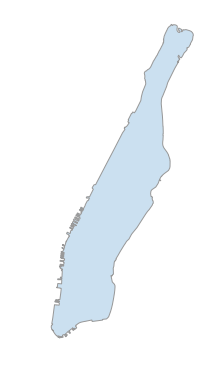

In [107]:
ox.plot_shape(ox.project_gdf(place1));

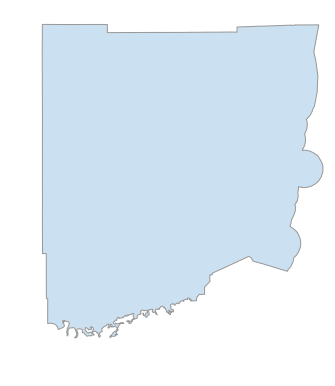

In [108]:
ox.plot_shape(ox.project_gdf(place2));

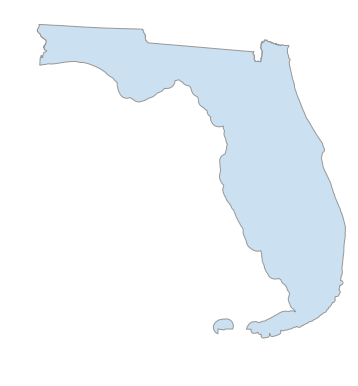

In [109]:
ox.plot_shape(ox.project_gdf(place3));

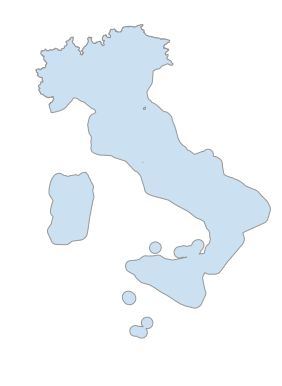

In [110]:
ox.plot_shape(ox.project_gdf(place4));

## Downloading street networks

Key functions: `graph_from_*` 
Can downloaded street networks using input:
  - bounding box (be careful of the lat/lng order)
  - address
  - place name
  - polygon
  - point

### Street network around an address

Get streets within 500 meters of the center of Northern Liberties

In [119]:
G = ox.graph_from_address("Northern Liberties, Philadelphia, PA", distance=500)

Project and plot it:

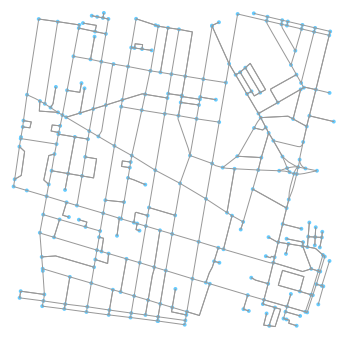

In [121]:
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected);

Remove the blue nodes:

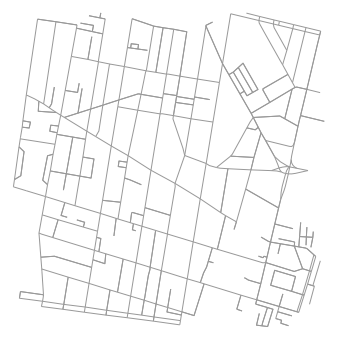

In [123]:
ox.plot_graph(G_projected, node_size=0);

Let's zoom out to 2,000 meters. This will take a little longer.

In [124]:
G = ox.graph_from_address("Northern Liberties, Philadelphia, PA", distance=2000)
G_projected = ox.project_graph(G)

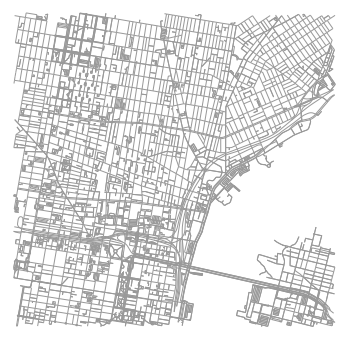

In [125]:
ox.plot_graph(G_projected, node_size=0);

### Getting different network types

- `drive` - get drivable public streets (but not service roads)
- `drive_service` - get drivable streets, including service roads
- `walk` - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
- `bike` - get all streets and paths that cyclists can use
- `all` - download all non-private OSM streets and paths
- `all_private` - download all OSM streets and paths, including private-access ones (default)

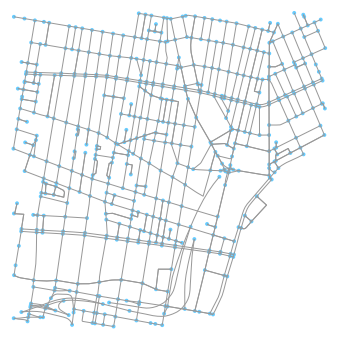

In [138]:
# the "drive" network
G = ox.graph_from_address("Northern Liberties, Philadelphia, PA", network_type='drive')
ox.plot_graph(G);

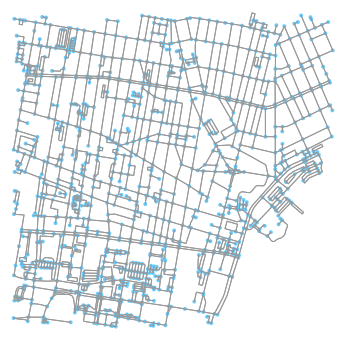

In [140]:
# the "walk" network
G = ox.graph_from_address("Northern Liberties, Philadelphia, PA", network_type='walk')
ox.plot_graph(ox.project_graph(G));

### Street network within a place boundary

Use `graph_from_place()` to get the streets within a specific OSM place.

**Note: the place query has to be resolved by OSM.**

In [134]:
berkeley = ox.graph_from_place("Berkeley, California", network_type='drive')

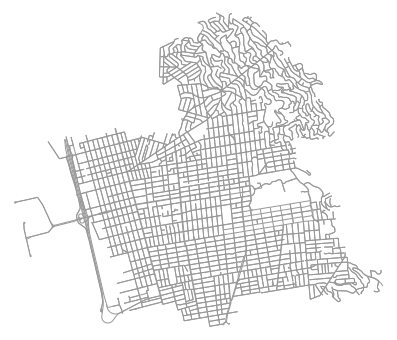

In [141]:
ox.plot_graph(ox.project_graph(berkeley), node_size=0);

### Streets within a specific polygon

**Example:** all streets within Northern Liberties and Fishtown

### First, Let's wrangle some Zillow boundaries

I downloaded Zillow neighborhood boundaries from https://www.zillow.com/howto/api/neighborhood-boundaries.htm

In [204]:
import geopandas as gpd

In [143]:
zillow = gpd.read_file("data/ZillowNeighborhoods-PA")

In [144]:
zillow.head()

State      County               City        Name RegionID  \
0    PA    Delaware          Wynnewood  Penn Wynne     6460   
1    PA  Montgomery          Wynnewood  Penn Wynne     6460   
2    PA     Chester  Easttown Township       Devon    11106   
3    PA        York      York Township        Spry    13975   
4    PA   Allegheny         Pittsburgh     Dormont    17799   

                                            geometry  
0  POLYGON ((-75.25734199999994 39.98964600000005...  
1  POLYGON ((-75.25734199999994 39.98964600000005...  
2  POLYGON ((-75.43213 40.064705, -75.43205317299...  
3  POLYGON ((-76.66168899999997 39.90929900000003...  
4  POLYGON ((-80.02962646899994 40.39713514800007...

Trim to Fishtown and Northern Liberties

In [146]:
sel = zillow['Name'].isin(['Fishtown', 'Northern Liberties'])
zillow = zillow.loc[sel]

In [149]:
zillow.head()

State        County          City                Name RegionID  \
166    PA  Philadelphia  Philadelphia            Fishtown   271178   
349    PA  Philadelphia  Philadelphia  Northern Liberties   753838   

                                              geometry  
166  POLYGON ((-75.11749725099997 39.98158943700003...  
349  POLYGON ((-75.13674114199995 39.96730077300003...

If you like OSMnx's plotting better than the GeoPandas plotting, you can use it on any GeoDataFrame

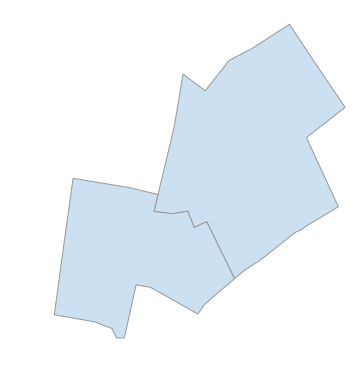

In [151]:
ox.plot_shape(zillow.to_crs(epsg=3857));

### Extract streets within these polygons

- Take the union of the polygons: `unary_union`
- Use `ox.graph_from_polygon()`

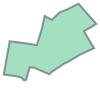

In [159]:
nolibs_fishtown = zillow.geometry.unary_union
nolibs_fishtown

In [186]:
# get the graph
G_nolibs_fishtown = ox.graph_from_polygon(nolibs_fishtown, network_type='drive')

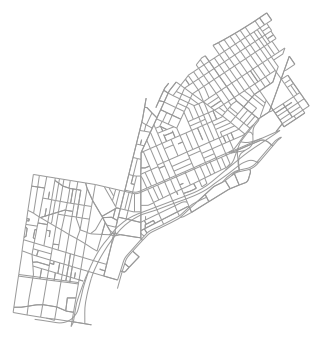

In [187]:
# viola!
ox.plot_graph(ox.project_graph(G_nolibs_fishtown), node_size=0);

We could also use `unary_union.convex_hull`. This will be an encompassing polygon around any set of geometries.

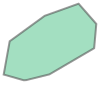

In [254]:
zillow.geometry.unary_union.convex_hull

## Converting from a graph to a GeoDataFrame

Key function: `ox.graph_to_gdfs()`

Can get a GeoDataFrame for both the nodes (points) and edges (lines)

In [188]:
# only get the edges
nolibs_edges = ox.graph_to_gdfs(G_nolibs_fishtown, edges=True, nodes=False)

In [236]:
# we have lots of data associated with each edge!
nolibs_edges.head()

bridge                                           geometry      highway  key  \
0    NaN  LINESTRING (-75.146372 39.9645781, -75.14655 3...  residential    0   
1    NaN  LINESTRING (-75.146372 39.9645781, -75.146269 ...     tertiary    1   
2    NaN  LINESTRING (-75.1461659 39.965443, -75.1460929...     tertiary    0   
3    NaN  LINESTRING (-75.1461659 39.965443, -75.1463711...  residential    0   
4    NaN  LINESTRING (-75.1472404 39.9578118, -75.147385...        trunk    0   

  lanes   length maxspeed               name  oneway                   osmid  \
0   NaN  117.685      NaN   North 5th Street   False                12109175   
1   NaN   97.779      NaN   North 5th Street    True                49961130   
2   NaN   32.185      NaN   North 5th Street    True                49961130   
3   NaN  117.685      NaN   North 5th Street   False                12109175   
4     5  135.861      NaN  Callowhill Street    True  [424804073, 121643778]   

   ref          u          v  
0  NaN  109729430  109729453  
1  NaN  109729430  109729453  
2  NaN  109729453  109729801  
3  NaN  109729453  109729430  
4  NaN  109729699  109811674

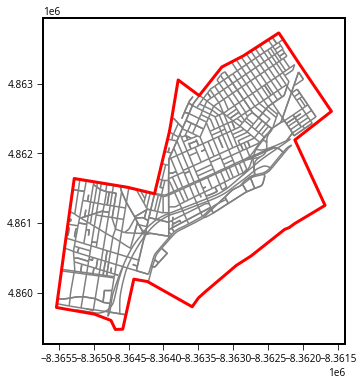

In [189]:
# plot it like any old GeoDataFrame
ax = nolibs_edges.to_crs(epsg=3857).plot(color='gray')

# add the neighborhood boundaries
boundary = gpd.GeoSeries([nolibs_fishtown], crs={'init':'epsg:4326'})
boundary.to_crs(epsg=3857).plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3, zorder=2);

## What can we do with the graph?

- Network-based statistics
- Routing
- Street orientations
- Visualizing crashes

And much more: see the [OSMnx repository of Jupyter notebook examples](https://github.com/gboeing/osmnx-examples/tree/master/notebooks)

## Network statistics

Two functions: 
- `ox.basic_stats()`
- `ox.extended_stats()`

In [202]:
ox.basic_stats(G_nolibs_fishtown)

{'n': 632,
 'm': 1263,
 'k_avg': 3.9968354430379747,
 'intersection_count': 615,
 'streets_per_node_avg': 3.4098101265822787,
 'streets_per_node_counts': {0: 0, 1: 17, 2: 1, 3: 329, 4: 278, 5: 5, 6: 2},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.02689873417721519,
  2: 0.0015822784810126582,
  3: 0.5205696202531646,
  4: 0.439873417721519,
  5: 0.007911392405063292,
  6: 0.0031645569620253164},
 'edge_length_total': 107542.74199999995,
 'edge_length_avg': 85.14864766429133,
 'street_length_total': 88880.72899999996,
 'street_length_avg': 86.37582993197276,
 'street_segments_count': 1029,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0160447165826367,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

## Finding the shortest route

We can use the `networkx` package to do network-based calculations

In [196]:
# two points in Northern Liberties / Fishtown
spring_garden_station = (39.960421, -75.140340)
frankford_hall = (39.969381, -75.134599)

# get the nearest network node to each point
orig_node = ox.get_nearest_node(G_nolibs_fishtown, spring_garden_station) 
dest_node = ox.get_nearest_node(G_nolibs_fishtown, frankford_hall) 

In [194]:
import networkx as nx

In [199]:
# get the shortest path --> just a list of node IDs
route = nx.shortest_path(G_nolibs_fishtown, orig_node, dest_node, weight='length')
route

[110156961,
 110156976,
 110240102,
 110240110,
 110156990,
 110408354,
 110150984,
 110151026,
 109812663,
 3405862196,
 110274404,
 786190278,
 786189685,
 786189751,
 786190146,
 786189922,
 110227372,
 110549183,
 110207010,
 1479201371,
 2178025740,
 110447532,
 109801799,
 109998370]

Use `ox.plot_graph_route()` to plot a graph and highlight a specific route

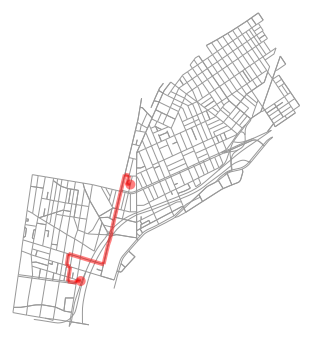

In [201]:
ox.plot_graph_route(G_nolibs_fishtown, route, node_size=0);

## Street Orientations

An amazing visualization of the orientations of city street networks from the author of OSMnx.

[See this blog post](https://geoffboeing.com/2018/07/comparing-city-street-orientations/)

<center>
    <img src=attachment:Screen%20Shot%202019-03-26%20at%2010.23.13%20PM.png width=700>
</center>
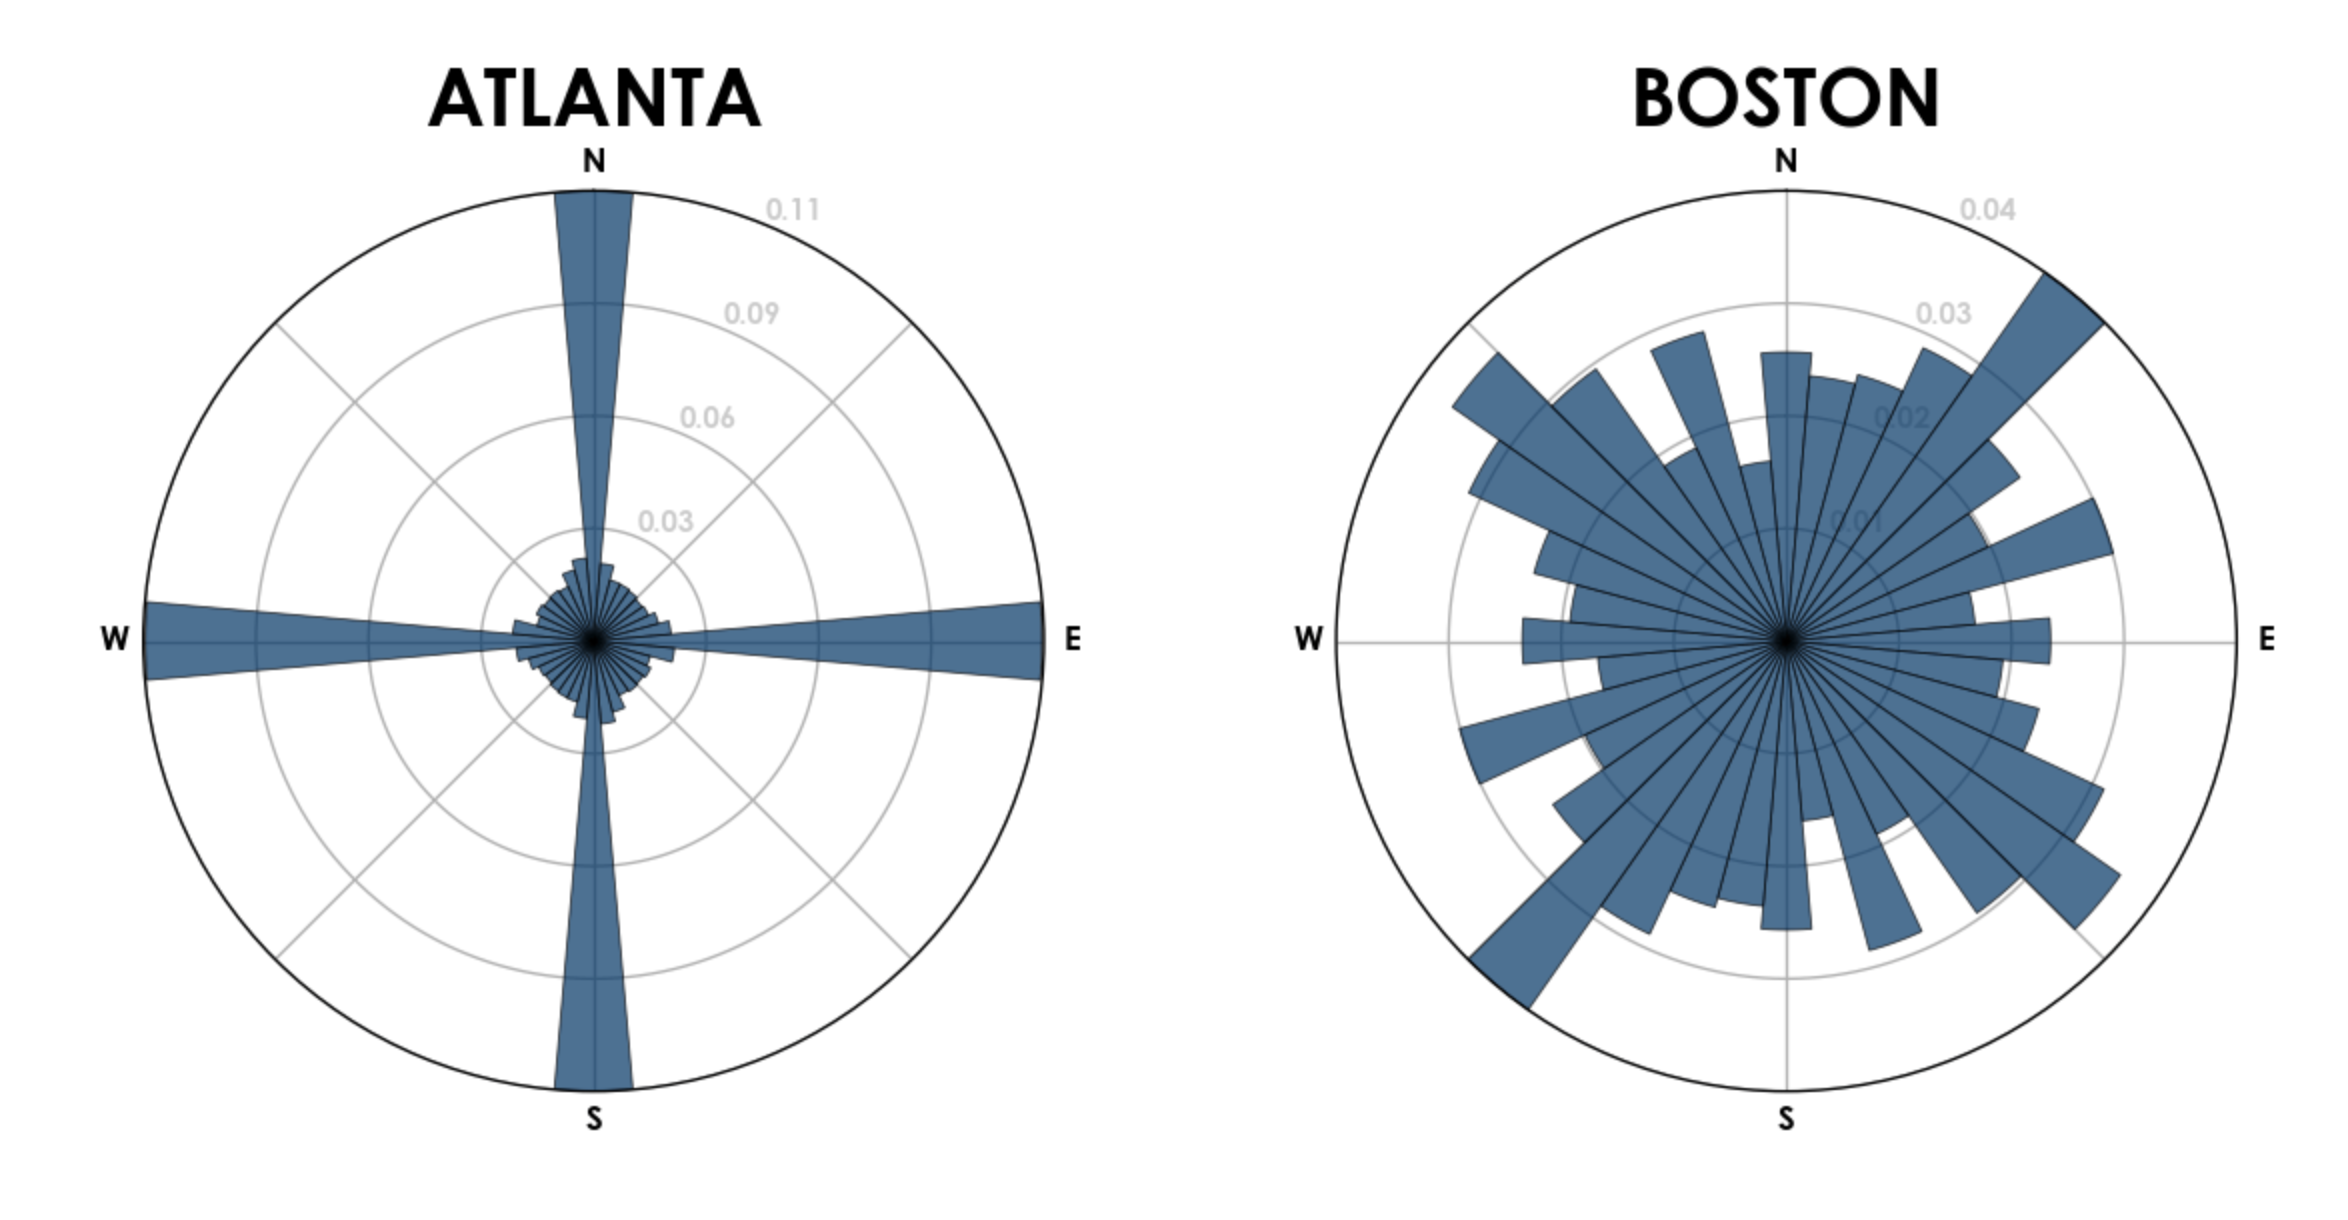

## Two steps: 

1. Add edge bearings to the data attributes of your graph
1. Loop over edges and extract those bearings into a pandas Series

In [207]:
# calculate edge bearings and visualize their frequency
G = ox.add_edge_bearings(G_nolibs_fishtown)

# extract bearings from the edges of the graph
bearings = pd.Series([data['bearing'] for u, v, data in G.edges(keys=False, data=True)])

## Plot a regular old histogram

We can use matplotlib's `hist` function

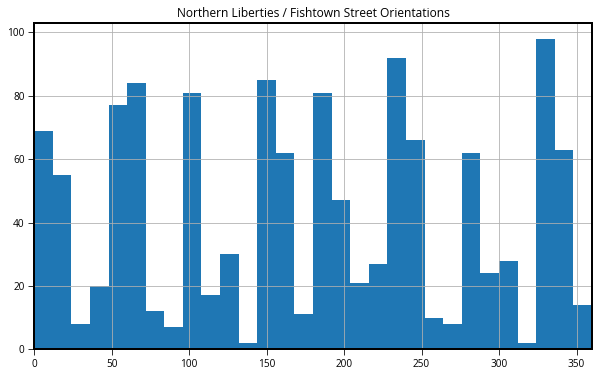

In [211]:
ax = bearings.hist(bins=30)
xlim = ax.set_xlim(0, 360)
ax.set_title('Northern Liberties / Fishtown Street Orientations')
plt.show()

## Can we do better? 

Radial histograms!

In [229]:
def plot_radial_hist(bearings, nbins=30):
    """
    Plot a radial histogram of the input edge bearings.
    """
    # equally spaced theta bins
    theta_bins = np.linspace(0, 360, nbins)
    
    # caculate the histogram
    bin_counts, bin_edges = np.histogram(bearings, bins=theta_bins)
    
    # the centers of the theta bins
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # the widths of each bins
    bin_widths = np.diff(bin_edges)

    # initializ a polar plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')
    
    # convert angles to radians
    bin_centers = np.radians(bin_centers)
    bin_widths = np.radians(bin_widths)
    
    # make a bar plot
    bars = ax.bar(x=bin_centers, height=bin_counts, width=bin_widths)
    
    return fig, ax


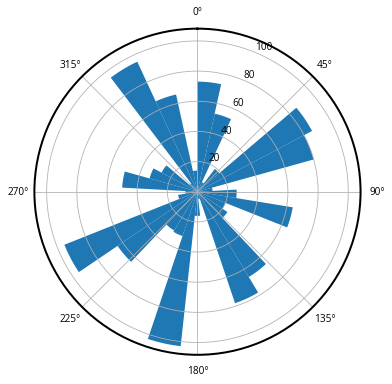

In [231]:
plot_radial_hist(bearings);

## Lab: Visualizing crash data in Philadelphia

### Step 1: choose your network region

There are a few different ways to do this: 
- Choose a Zillow neighborhood, load the shape file, and get its boundary
- Choose an address or lat/lng point and get the network within a given distance
- Use a bounding box (see the tool http://boundingbox.klokantech.com/ for helping pick a bounding box)

### Step 2: get the street network graph

Use the appropriate function from OSMnx, e.g., `ox.graph_from_*`


### Step 3: Convert your network graph edges to a GeoDataFrame

See: `ox.graph_to_gdfs()`

### Step 4: Load PennDOT crash data

Data for 2017 crashes (of all types) is available at the following path:

`./data/penndot_crashes/Philadelphia_CRASH_2017.csv`

Downloaded from: https://crashinfo.penndot.gov/PCIT/welcome.html



### Step 5: Convert the crash data to a GeoDataFrame

You will need to use the `DEC_LAT` and `DEC_LONG` columns for latitude and longitude.

The full data dictionary for the data is [available here].(http://pennshare.maps.arcgis.com/sharing/rest/content/items/ffe20c6c3c594389b275c6772a281bcd/data)

For help on the Pandas to GeoPandas conversion, see [this documentation](https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html).

### Step 6: Trim the crash data

1. Get the boundary of the edges data frame (from Step #3). Accessing the `.geometry.unary_union.convex_hull` property will give you a nice outer boundary region.
1. Trim the crashes using the `within()` function of the crash GeoDataFrame to find which crashes are within the boundary.

### Step 7: Find the nearest edge for each crash

See: `ox.get_nearest_edges()`. It takes three arguments:

- the network graph
- the latitude of your crash data (the `y` attribute of the `geometry` column)
- the longitude of your crash data (the `x` attribute of the `geometry` column)

You will get a list of `(u,v)` where each `u` and `v` are a node ID.

### Step 8: Calculate the total number of crashes per street

1. Make a DataFrame from your data from Step 7 with two columns, `u` and `v`
1. Group by `u` and `v` and calculate the size
1. Reset the index (and name your `size()` column)

### Step 9: Merge your edges GeoDataFrame and crash count DataFrame

You can use pandas to merge them on the `u` and `v` columns. This will associate the total crash count with each edge in the street network. 

**Tips:** 
   - Use a `left` merge where the first argument of the merge is the edges GeoDataFrame. This ensures no edges are removed during the merge.
   - Use the `fillna(0)` function to fill in missing crash count values with zero.

### Step 10: Get the top 10 streets with crashes and plot the streets

You can use GeoPandas to make the plot, coloring the streets by your column of crash counts. 

**Tip:** if the crashes are concentrated are concentrated on a few specific streets, try setting the `vmax` parameter to a relatively low number to limit the dynamic range of the color map (it sets the upper bound of the color map).

## Extra exercise: plot a radial histogram of your favorite region

Take a look at the city-wide results from https://geoffboeing.com/2018/07/comparing-city-street-orientations/

### Many more possibilities...

A lot of interesting exploration avenues: the crash data has info on speed, conditions, type of crash, etc, and the data goes back to 1998. 

Data is from https://crashinfo.penndot.gov/PCIT/welcome.html. See the link for "Public Datasets".

**Cool idea / exercise for home:** make a GIF of the crashes in Philadelphia for each year since 1998.

## Part 2:  Pandana

"Pandas Network Analysis - dataframes of network queries, quickly"

A complementary set of OSM-related features: 
- Downloading OSM-based networks
- Extracting amenity data (so-called "Points of Interest")
- Calculating network-constrained distances

- [GitHub](https://github.com/UDST/pandana)
- [Jupyter Notebook Examples](https://github.com/UDST/pandana/tree/master/examples)
- [Documentation](http://udst.github.io/pandana/)

## Step 1: Get amenity data

Key function: `osm.node_query()`

This will extract amenities within a given bounding box.

In [4]:
import pandas as pnda
from pandana.loaders import osm

In [5]:
osm.node_query?

Get the bounding box for Northern Liberties / Fishtown:

In [8]:
boundary = nolibs_fishtown.bounds
boundary

NameError: name 'nolibs_fishtown' is not defined

In [7]:
[lng_min, lat_min, lng_max, lat_max] = boundary

NameError: name 'boundary' is not defined

In [310]:
# query OSM
poi_df = osm.node_query(lat_min, lng_min, lat_max, lng_max)

# remove missing data
poi_df = poi_df.dropna(subset=['amenity'])

In [311]:
poi_df.head()

access addr:city addr:country addr:full addr:housename  \
id                                                                 
357274893    NaN       NaN          NaN       NaN            NaN   
357280489    NaN       NaN          NaN       NaN            NaN   
357283515    NaN       NaN          NaN       NaN            NaN   
357288962    NaN       NaN          NaN       NaN            NaN   
357292065    NaN       NaN          NaN       NaN            NaN   

          addr:housenumber addr:place addr:postcode addr:state addr:street  \
id                                                                           
357274893              NaN        NaN           NaN        NaN         NaN   
357280489              NaN        NaN           NaN        NaN         NaN   
357283515              NaN        NaN           NaN        NaN         NaN   
357288962              NaN        NaN           NaN        NaN         NaN   
357292065              NaN        NaN           NaN        NaN         NaN   

           ... tower:type traffic_signals traffic_signals:direction tram  \
id         ...                                                             
357274893  ...        NaN             NaN                       NaN  NaN   
357280489  ...        NaN             NaN                       NaN  NaN   
357283515  ...        NaN             NaN                       NaN  NaN   
357288962  ...        NaN             NaN                       NaN  NaN   
357292065  ...        NaN             NaN                       NaN  NaN   

          unisex website wheelchair wifi wikidata wikipedia  
id                                                           
357274893    NaN     NaN        NaN  NaN      NaN       NaN  
357280489    NaN     NaN        NaN  NaN      NaN       NaN  
357283515    NaN     NaN        NaN  NaN      NaN       NaN  
357288962    NaN     NaN        NaN  NaN      NaN       NaN  
357292065    NaN     NaN        NaN  NaN      NaN       NaN  

[5 rows x 121 columns]

In [321]:
poi_df[['lat', 'lon', 'amenity']].head()

lat        lon amenity
id                                     
357274893  39.972335 -75.130176  school
357280489  39.969835 -75.126565  school
357283515  39.976224 -75.116842  school
357288962  39.979279 -75.127121  school
357292065  39.984557 -75.134065  school

## Explore the amenities in this region

For the full list of amenities, see the [OSM Wikipedia](https://wiki.openstreetmap.org/wiki/Key:amenity)

In [319]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

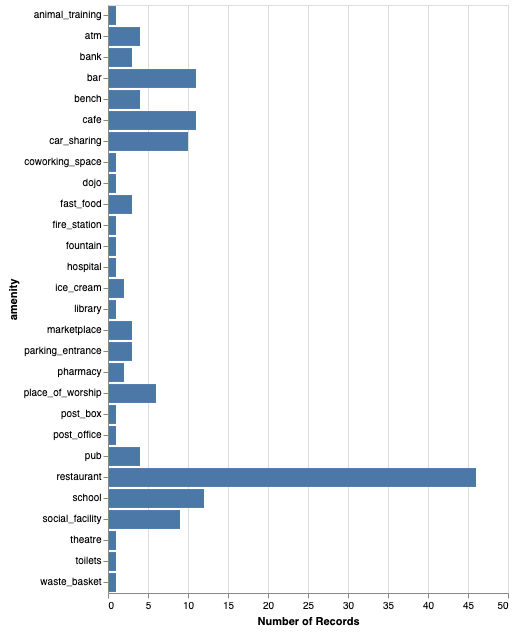

In [320]:
(alt.Chart(poi_df)
.mark_bar()
.encode(y='amenity', x='count()', tooltip=['amenity', 'count()']))

## Step 2: Create a Pandana network

- Key function: `pdna_network_from_bbox()` 
- It takes a bounding box and returns the OSM network within that region. 
- Multiple network types: 'walk' and 'drive'

In [356]:
net = osm.pdna_network_from_bbox(lat_min, lng_min, lat_max, lng_max, network_type='walk')

INFO:osmnet:Requesting network data within bounding box from Overpass API in 1 request(s)
INFO:osmnet:Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](39.95549270,-75.14887639,39.98475670,-75.11346406);>;);out;'}"


Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](39.95549270,-75.14887639,39.98475670,-75.11346406);>;);out;'}"


INFO:osmnet:Downloaded 816.9KB from www.overpass-api.de in 1.22 seconds
INFO:osmnet:Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.24 seconds
INFO:osmnet:Returning OSM data with 4,465 nodes and 1,219 ways...


Downloaded 816.9KB from www.overpass-api.de in 1.22 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.24 seconds
Returning OSM data with 4,465 nodes and 1,219 ways...


INFO:osmnet:Edge node pairs completed. Took 3.25 seconds


Edge node pairs completed. Took 3.25 seconds


INFO:osmnet:Returning processed graph with 1,958 nodes and 3,061 edges...
INFO:osmnet:Completed OSM data download and Pandana node and edge table creation in 5.00 seconds
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')


Returning processed graph with 1,958 nodes and 3,061 edges...
Completed OSM data download and Pandana node and edge table creation in 5.00 seconds


/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


### Step 3: Tell the network the location of amenities

Key function: `network.set_pois()`

In [362]:
# sensible defaults
max_distance = 2000 # in meters
num_pois = 10 # only need the 10 nearest POI to each point in the network

amenities = ['restaurant', 'bar', 'school', 'car_sharing']
for amenity in amenities:
    
    # get the subset of amenities for this type
    pois_subset = poi_df[poi_df['amenity']==amenity]
    
    # set the POI, using the longitude and latitude of POI
    net.set_pois(amenity, max_distance, num_pois, pois_subset['lon'], pois_subset['lat'])

/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [363]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (lat_max - lat_min) / (lng_max - lng_min)
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':20, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

### Step 4: plot the walking distance to the nearest POI

For every point on the network, find the nth nearest POI, calculate the distance, and color that point according to the distance.

1. Use `network.nearest_poi()` to get distances from nodes to nearest POIs
1. Merge coordinates of network nodes with distances to nearest POIs
1. Plot the node coordinates, colored by distance to nth nearest POI

### 1. Use `network.nearest_poi()` to get distances from nodes to nearest POIs

In [2]:
amenity = 'bars'
access = net.nearest_pois(distance=1000, category=amenity, num_pois=num_pois)

NameError: name 'net' is not defined

In [ ]:
access.head()

### 2. Merge coordinates of network nodes with distances to nearest POIs

In [1]:
def to_geopandas(df):
    """
    Utility function to convert from DataFrame to GeoDataFrame
    """
    from shapely.geometry import Point
    df['geometry'] = df.apply(lambda row: Point(row['x'], row['y']), axis=1)
    return gpd.GeoDataFrame(df, geometry='geometry', crs={'init':'epsg:4326'})

In [ ]:
nodes = pd.merge(net.nodes_df, access, left_index=True, right_index=True)    
nodes = to_geopandas(nodes)

In [ ]:
nodes.head()

### And now plot it!

Let's define a function to do this for us, since we'll repeat this plot multiple times

In [2]:
def plot_walking_distance(net, amenity, distance=1000, n=1):

    # subset of POI
    poi_subset = poi_df[poi_df['amenity']==amenity]
    
    # get the distances to nearest num_pois POI
    access = net.nearest_pois(distance=1000, category=amenity, num_pois=num_pois)

    # merge node positions and distances to nearest PO
    nodes = pd.merge(net.nodes_df, access, left_index=True, right_index=True)    
    nodes = to_geopandas(nodes)
    
    # plot the distance to the nth nearest amenity
    ax = nodes.plot(column=nodes[n], legend=True, **plot_kwargs)
    
    # add the amenities as stars
    for i, row in poi_subset.iterrows():
        ax.scatter(row['lon'], row['lat'], color='red', s=100, marker='*')
    
    # format
    ax.set_facecolor('black')
    ax.figure.set_size_inches(fig_kwargs['figsize'])
    
    # set extent
    [xmin, ymin, xmax, ymax] = nodes.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    return ax

### Evaluating amenity choice

The difference between maps to the nearest amenity and for example, the 5th nearest amenity tells us about the options consumers have

## Example: bars

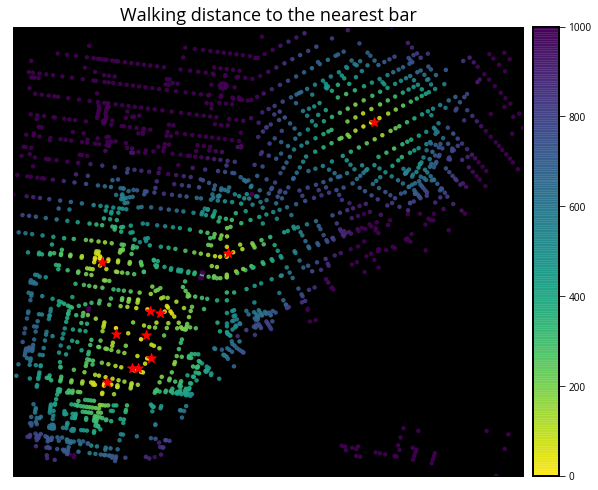

In [379]:
ax = plot_walking_distance(net, "bar", n=1)
ax.set_title("Walking distance to the nearest bar", fontsize=18);

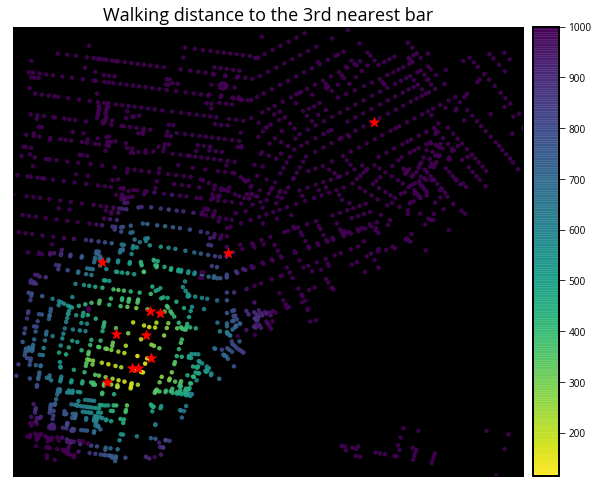

In [383]:
ax = plot_walking_distance(net, "bar", n=3)
ax.set_title("Walking distance to the 3rd nearest bar", fontsize=18);

## Example: schools

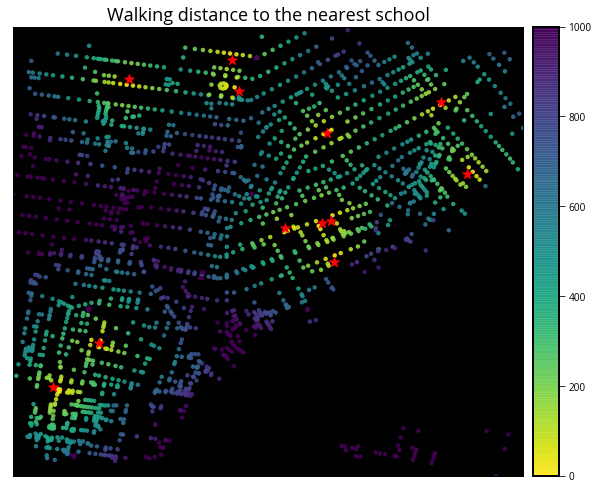

In [382]:
ax = plot_walking_distance(net, "school", n=1)
ax.set_title("Walking distance to the nearest school", fontsize=18);

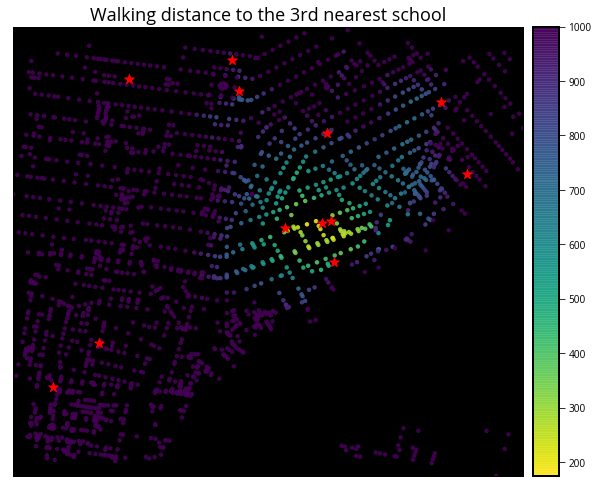

In [381]:
ax = plot_walking_distance(net, "school", n=3)
ax.set_title("Walking distance to the 3rd nearest school", fontsize=18);

## Example: restaurants

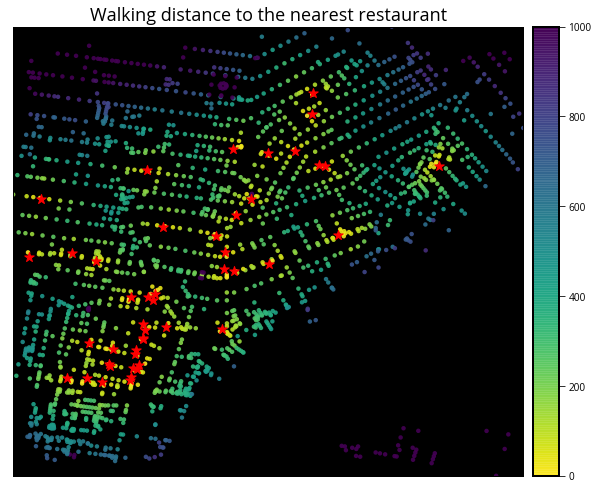

In [384]:
ax = plot_walking_distance(net, "restaurant", n=1)
ax.set_title("Walking distance to the nearest restaurant", fontsize=18);

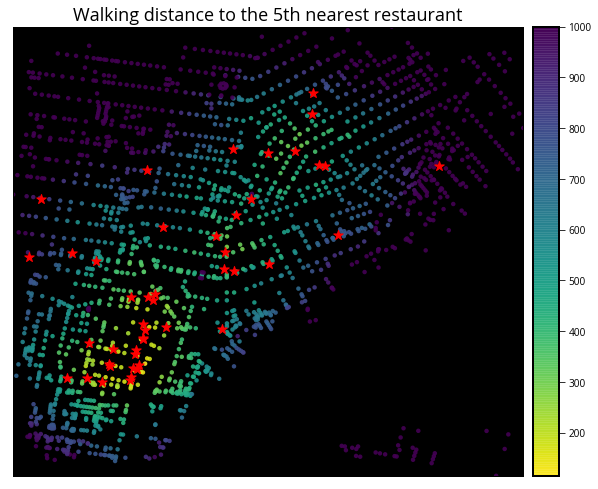

In [387]:
ax = plot_walking_distance(net, "restaurant", n=5)
ax.set_title("Walking distance to the 5th nearest restaurant", fontsize=18);

## Example: car sharing

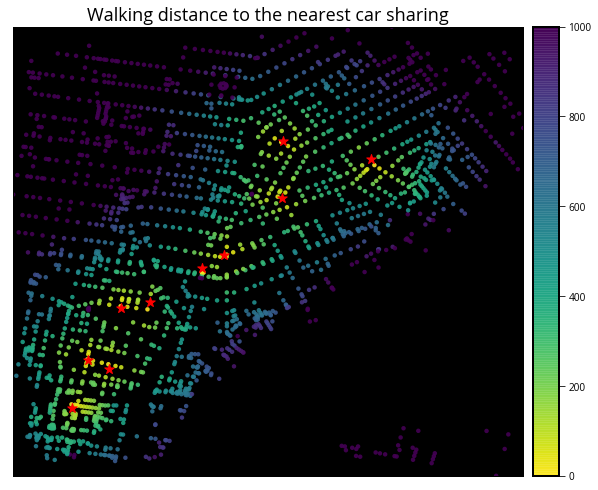

In [388]:
ax = plot_walking_distance(net, "car_sharing", n=1)
ax.set_title("Walking distance to the nearest car sharing", fontsize=18);

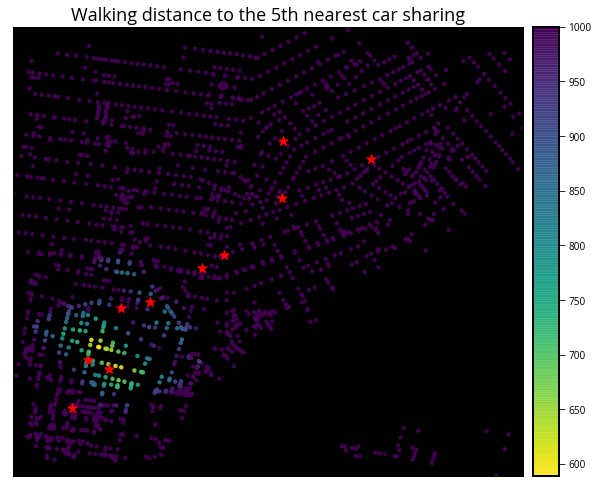

In [389]:
ax = plot_walking_distance(net, "car_sharing", n=5)
ax.set_title("Walking distance to the 5th nearest car sharing", fontsize=18);

## Exercise: explore amenities in the neighborhood of your choice

Many, many more amenities are logged throughout the city. Pick your favorite neighborhood and explore. 

See [this page](https://wiki.openstreetmap.org/wiki/Key:amenity) for the full list of amenities.